In [98]:
# Imports
import json
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import numpy as np
from tqdm import tqdm
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

SEED = 662 # Seed for reproducibility
CWD = pathlib.Path("").parent

In [102]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics.xlsx', sheet_name=None)
dfs['Suffrage']

,Suffrage_data_loss,Suffrage_data_quality_is_good,Suffrage_data_quality_reason,Suffrage_session_count,Suffrage_total_fix_count_quiz,Suffrage_total_fix_count_pdf,Suffrage_total_dwell_time_pdf,Suffrage_total_duration,Suffrage_total_fix_count,Suffrage_coldread_coverage_word_%,...,Suffrage_qa_duration,Suffrage_qa_fix_count_pdf,Suffrage_qa_saccade_line_regression_rate_%,Suffrage_qa_fix_dispersion_mean,Suffrage_qa_saccade_horizontal_later_%,Suffrage_qa_dwell_time_pdf,id,valor_MAP,group,Suffrage_score
0,0,1,GOOD,1,1789,1907,422.11,1095.57,3827,33.72,...,902.53,1318,6.04,1.93,16.69,287.04,103,220,B,0.666667
1,0,1,GOOD,1,706,739,424.00,1433.24,1534,24.46,...,1049.66,415,2.80,1.94,6.78,240.05,104,189,B,0.444444
2,0,0,PARTIAL_LOSS,1,0,408,95.58,114.67,417,18.38,...,0.00,0,0.00,0.00,0.00,0.00,105,207,B,0.444444
3,0,1,GOOD,1,1319,1147,234.44,1508.94,2719,12.45,...,1250.47,1006,2.42,2.78,7.50,150.77,108,214,B,0.444444
4,0,1,GOOD,1,0,217,58.47,162.27,252,16.06,...,0.00,0,0.00,0.00,0.00,0.00,109,226,B,0.388889
5,0,0,LOW_DATA_COUNT,1,0,9,0.94,2.04,9,0.14,...,0.00,0,0.00,0.00,0.00,0.00,111,238,B,0.888889
6,0,1,GOOD,1,795,1313,398.68,1451.75,2281,28.65,...,1224.77,779,4.08,2.72,11.37,292.21,115,219,B,0.500000
7,0,1,GOOD,2,1209,867,419.31,1497.90,2155,36.32,...,765.58,85,0.38,3.30,1.06,17.57,116,218,B,0.444444
8,0,1,GOOD,1,765,165,65.74,1083.46,1052,1.45,...,1036.49,128,0.82,1.95,3.89,51.74,117,190,B,0.444444
9,0,1,GOOD,1,2439,1982,531.32,1606.26,4551,58.03,...,1051.35,444,0.67,2.30,3.90,110.26,120,201,B,0.555556


In [85]:
# Preprocessing
## Combine all assignments into one dataframe
assignment_names = ['Suffrage', 'Ants', 'Clouds', 'Waterclocks', 'Lizards', 'Tastes', 'Lodgepoles']

# Select only the suffrage passage
dfs = {'Suffrage': dfs['Suffrage']} # Other assignments are too small and result in high variance

all_dfs = []
for assignment_name, df in dfs.items():
    # Drop unnecessary columns
    new_df = df.drop(columns=['group', 'id', f"{assignment_name}_data_loss", f"{assignment_name}_session_count", f"{assignment_name}_data_quality_reason", f"{assignment_name}_data_quality_is_good"])

    # Drop all nan rows
    new_df = new_df.dropna()

    # Rename columns from f"{assignment_name}.<metric>" to f"<metric>"
    new_df.columns = [col.replace(f"{assignment_name}_", "") for col in new_df.columns]

    # Drop any column with "backwards" in its name
    new_df = new_df[[col for col in new_df.columns if 'backward' not in col]]
    # new_df = new_df[[col for col in new_df.columns if 'std' not in col]]
    # new_df = new_df[[col for col in new_df.columns if 'wpm_mean' not in col]]
    # new_df = new_df[[col for col in new_df.columns if 'wpm' not in col]]
    # new_df = new_df[[col for col in new_df.columns if 'qa' not in col]]

    # Only keep the following metrics that include the following in their name
    all_dfs.append(new_df)

# Concatenate all dataframes
all_df = pd.concat(all_dfs)
all_df

,total_fix_count_quiz,total_fix_count_pdf,total_dwell_time_pdf,total_duration,total_fix_count,coldread_coverage_word_%,coldread_saccade_vertical_next_target_%,coldread_dwell_time_pdf,coldread_saccade_line_regression_rate_%,coldread_coverage_page_%,...,qa_saccade_vertical_next_target_%,qa_coverage_caption_%,qa_duration,qa_fix_count_pdf,qa_saccade_line_regression_rate_%,qa_fix_dispersion_mean,qa_saccade_horizontal_later_%,qa_dwell_time_pdf,valor_MAP,score
0,1789,1907,422.11,1095.57,3827,33.72,59.73,135.08,11.31,100.00,...,27.69,50,902.53,1318,6.04,1.93,16.69,287.04,220,0.666667
1,706,739,424.00,1433.24,1534,24.46,28.81,183.95,4.52,100.00,...,11.10,50,1049.66,415,2.80,1.94,6.78,240.05,189,0.444444
3,1319,1147,234.44,1508.94,2719,12.45,29.38,83.68,3.12,100.00,...,14.03,100,1250.47,1006,2.42,2.78,7.50,150.77,214,0.444444
6,795,1313,398.68,1451.75,2281,28.65,52.04,106.48,6.48,100.00,...,19.87,50,1224.77,779,4.08,2.72,11.37,292.21,219,0.500000
7,1209,867,419.31,1497.90,2155,36.32,47.14,401.73,5.71,100.00,...,1.90,0,765.58,85,0.38,3.30,1.06,17.57,218,0.444444
9,2439,1982,531.32,1606.26,4551,58.03,73.78,421.06,7.17,100.00,...,6.15,50,1051.35,444,0.67,2.30,3.90,110.26,201,0.555556
10,1099,1182,416.52,1203.80,2510,40.38,46.12,287.73,6.85,100.00,...,10.59,50,762.83,394,1.96,2.29,5.81,128.80,225,0.611111
11,382,893,250.48,1095.82,1342,34.88,60.76,165.89,6.79,100.00,...,21.41,0,771.04,297,2.57,2.59,14.63,84.59,209,0.555556
12,803,2117,463.05,800.66,2994,58.18,77.85,299.14,10.07,100.00,...,28.89,50,431.69,786,4.99,3.29,16.18,163.92,225,0.666667
15,2118,1963,452.05,1421.55,4396,53.69,65.43,264.62,10.09,100.00,...,15.63,0,1041.12,832,2.86,2.44,9.66,187.43,230,0.777778


In [86]:
# Split data into features and target
labels = ['valor_MAP', 'score']
in_features = [col for col in all_df.columns if col not in labels]
X = all_df[in_features]
y = all_df['valor_MAP'] # starting with the score

In [87]:
# Remove redundant features
# Method 1: Correlation Threshold
corr_matrix = X.corr().abs()

# Identify highly correlated features (e.g., correlation > 0.85)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

# Drop redundant features
X_filtered = X.drop(columns=to_drop)

print(f"Removed {len(to_drop)} redundant features: {to_drop}")

Removed 17 redundant features: ['total_fix_count', 'coldread_coverage_paragraph_%', 'coldread_coverage_line_%', 'coldread_fix_count_pdf', 'coldread_fix_count', 'coldread_saccade_horizontal_later_%', 'coldread_stopwatch_wpm', 'qa_fix_count', 'qa_fix_count_quiz', 'qa_saccade_vertical_later_%', 'qa_dwell_time_quiz', 'qa_coverage_line_%', 'qa_coverage_word_%', 'qa_duration', 'qa_fix_count_pdf', 'qa_saccade_line_regression_rate_%', 'qa_saccade_horizontal_later_%']


In [88]:
# First determine the correlation between the metrics and the final grade
# Calculate the correlation between the features and the target
correlation = X_filtered.corrwith(y)
correlation = correlation.sort_values(ascending=False)
correlation

coldread_saccade_line_regression_rate_%    0.529624
coldread_coverage_word_%                   0.373190
coldread_saccade_vertical_later_%          0.288304
total_fix_count_pdf                        0.282185
coldread_fix_dispersion_mean               0.278403
coldread_saccade_vertical_next_target_%    0.275650
coldread_saccade_regression_rate_%         0.273928
qa_saccade_vertical_next_target_%          0.251833
qa_fix_dispersion_mean                     0.170698
coldread_gaze_wpm_median                   0.165162
coldread_coverage_quote_%                  0.152179
qa_coverage_heading_%                      0.123695
coldread_gaze_wpm_std                      0.116995
qa_coverage_title_%                        0.110543
qa_dwell_time_pdf                          0.092545
total_fix_count_quiz                       0.082390
qa_saccade_regression_rate_%               0.070285
coldread_coverage_page_%                   0.062516
total_dwell_time_pdf                       0.057132
coldread_fix

In [100]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=SEED),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=SEED),
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor()
}

# Only select the positive correlated features
top_features = correlation[correlation > 0].index
X_filtered = X_filtered[top_features]

# Split dataset
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=SEED)

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T

# Save results to Excel
results_df.to_excel(CWD / 'data' / 'output' / 'regression_results.xlsx')
results_df


,MAE,MSE,R²
Linear Regression,16.033044,392.191806,-0.583414
Random Forest,9.533750,107.669338,0.565302
XGBoost,5.949888,45.509882,0.816261
SVM,11.731872,231.919010,0.063663
Decision Tree,11.625000,179.625000,0.274792


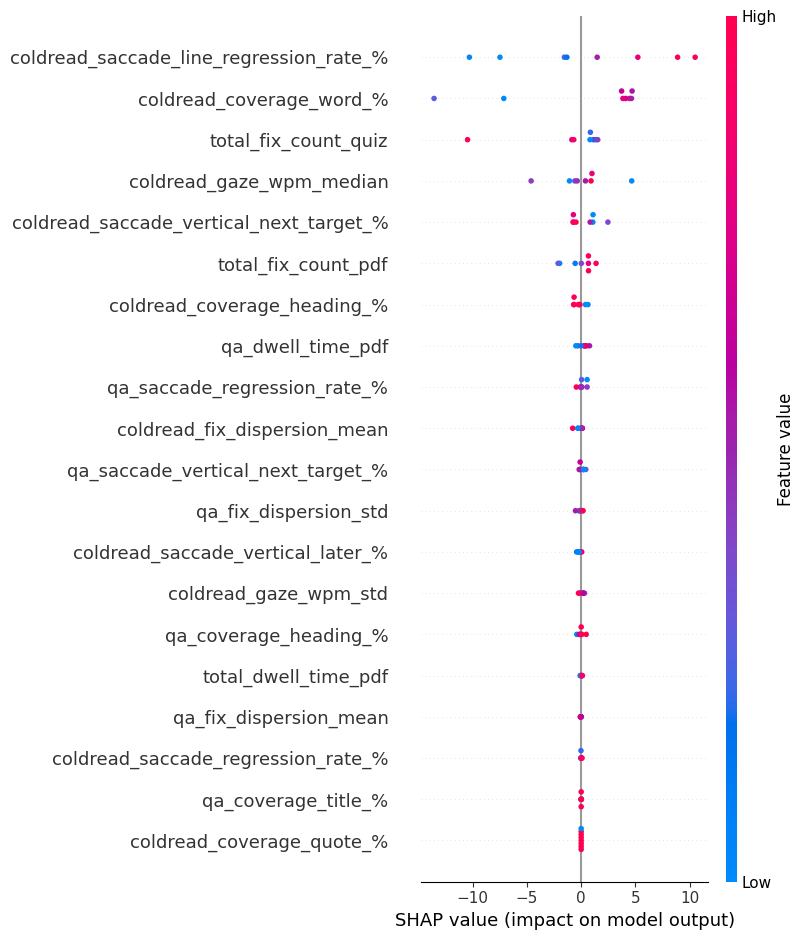

In [90]:
# Train the best model (choose based on R²)
best_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=SEED)
best_model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

In [93]:
# Compute feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=SEED)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_filtered.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

feature_importance_df


,Feature,Importance
1,coldread_coverage_word_%,0.487873
0,coldread_saccade_line_regression_rate_%,0.413447
9,coldread_gaze_wpm_median,0.047015
3,total_fix_count_pdf,0.043184
15,total_fix_count_quiz,0.042314
5,coldread_saccade_vertical_next_target_%,0.013554
16,qa_saccade_regression_rate_%,0.012298
11,qa_coverage_heading_%,0.008190
14,qa_dwell_time_pdf,0.005004
7,qa_saccade_vertical_next_target_%,0.002321


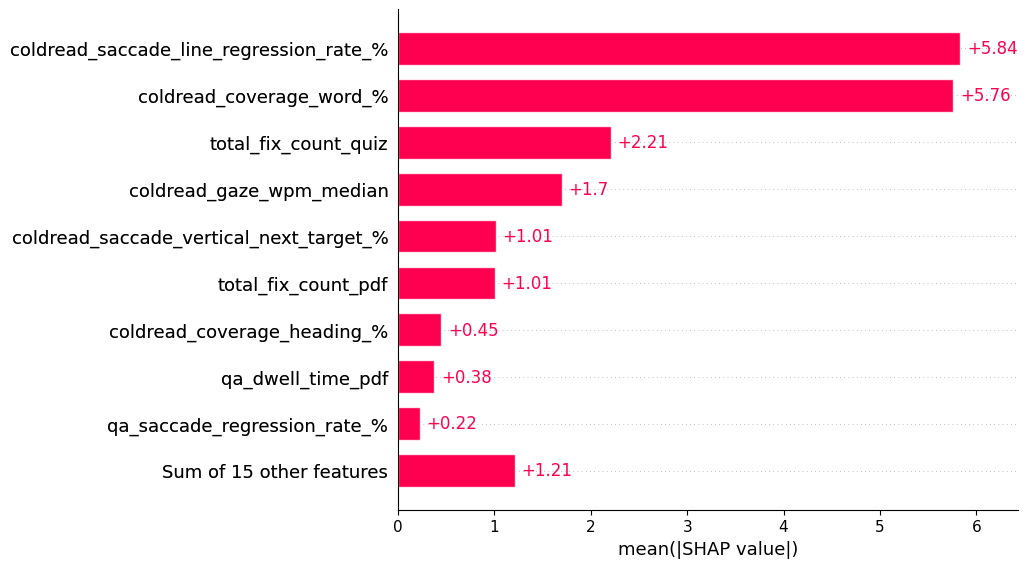

In [94]:
shap.plots.bar(shap_values)

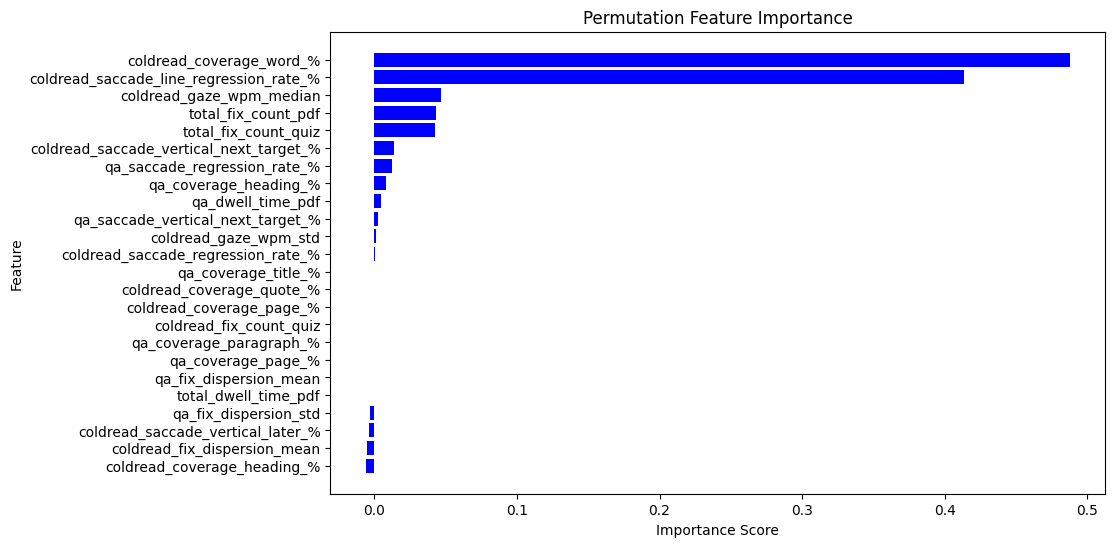

In [95]:
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [96]:
# Save top 5 features into a JSON file
top_features = feature_importance_df["Feature"].head(5)
top_features = {"features": top_features.to_list()}
with open("top_features.json", "w") as f:
    f.write(json.dumps(top_features, indent=4))